# Отток клиентов

<div class="alert alert-success">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Георгий, привет еще раз! Сейчас будет общая вводная, как в прошлый раз, затем перейдем к проекту
</div>


<div class="alert alert-info">
Привет! Меня зовут Никита Мишин и я буду твоим ревьюером по этому проекты.
Для простоты предлагаю общение на 'ты'. Буду предполагать, что ты не против:) 
Если более предпочтительно обращение на 'Вы', пиши, не стесняйся.
Также если будут возникать вопросы, аналогично, пиши:)

Предлагаю работать в известном тебе итеративном формате.
Итерация состоит в моей проверке твоего решения. 
После решения могут остаться какие-то недочеты, которые я попрошу тебя устранить, ты их исправляешь и я проверяю твои решения.
    Оставленные мною комментарии могут быть разного вида:
   
    - зеленый: элегантные решения, которые тебе стоит запомнит и в дальнейшем взять на вооружение:) 
    
    - желтый: сигнал о том, что есть некритичная вещь(не всегда ошибка), что нужно точно поправить в следующей работе, даже желательно в этой (полезно, в первую очередь, для тебя:) ).Также это рекомендации на будущее    

    - красный: недочет, который нужно исправить в этой работе, для того, чтобы она была принята
    
    - синий: полезная информация, доп ресурсы, "вопросы на подумать"

Также попрошу не удалять мои комментарии:) <a class="tocSkip">
</div>

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# 0. Предварительная подготовка

In [1]:
import pandas as pd
import itertools as it
import time
import warnings
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import f1_score 
from sklearn.metrics import recall_score 
from sklearn.metrics import precision_score 
from sklearn.metrics import roc_auc_score 
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve 

pd.options.mode.chained_assignment = None
pd.options.display.max_colwidth = 999
warnings.filterwarnings('ignore')

GLOBAL_RANDOM_STATE = 12345

In [2]:
# groupby + count по нужной колонке
def show_shares(df: pd.DataFrame, group_col: str, count_col: str = None) -> pd.DataFrame:
    if(count_col == None):
        data = df[[group_col]]
        data[count_col] = 1
    else: 
        data = df[[group_col, count_col]]
    return data\
    .groupby(by=[group_col])\
    .agg('count')\
    .reset_index()\
    .rename(columns={count_col:'count'})\
    .assign(share = lambda x: x['count'] / data.shape[0])
    

In [3]:
# построение гистограм для одного и более фреймов
def hist(onecolumn_frames_list=[], xlab='', ylab='', title='', bins=10, xrange=None, figsize=(10,5), fontsize=12):
    fig, ax = plt.subplots()
    rmin, rmax = 999999999999999, 0
    series_list, legend_list = [], []
    alpha, alpha_step = 1, int((40 / len(onecolumn_frames_list))) / 100 # полная прозрачность нам не нужна 
    for i in onecolumn_frames_list:
        column_name = i.columns[0]
        legend_list.append(column_name)
        series_list.append(i[column_name])
    for i in series_list:
        rmin = i.min() if i.min() < rmin else rmin
        rmax = i.max() if i.max() > rmax else rmax
        ax.hist(i,bins=bins, alpha=alpha)
        alpha -= alpha_step
    rrange = xrange if xrange != None else (rmin,rmax)
    ax.set_title(title)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_xlim(rrange)
    ax.legend(legend_list)
    fig.set_size_inches(figsize)
    plt.rcParams.update({'font.size': fontsize})
    plt.grid()
    fig.tight_layout()

In [4]:
# построение boxplot для нескольких одноколоночных датафреймов
def boxplot(onecolumn_frames_list=[], xlab='', ylab='', title='', vert=False, figsize=(10,5), fontsize=12, showfliers=True, notch=False):
    fig, ax = plt.subplots()
    series_list, legend_list, lowers, uppers = [], [], [], []
    label_info = ""
    for i in onecolumn_frames_list:
        column_name = i.columns[0]
        legend_list.append(column_name)
        series_list.append(i[column_name])
        q1 = i[column_name].quantile(0.25)
        q3 = i[column_name].quantile(0.75) 
        iqr = q3 - q1
        median = i[column_name].median()
        mean = i[column_name].mean()
        lower = q1 - 1.5*iqr
        if lower < 0:
            lower = 0
        upper = q3 + 1.5*iqr   
        lowers.append(lower)
        uppers.append(upper)
        label_info += f"\n {column_name}: границы усов = [{round(lower,2)}; {round(upper,2)}], среднее = {round(mean,2)}, медиана = {round(median,2)}, Q1 = {round(q1,2)}, Q3 = {round(q3,2)}" 
        
    bp = ax.boxplot(
        series_list,
        vert=vert,
        patch_artist=True,
        labels=legend_list,
        showfliers=showfliers,
        notch=notch, 
        sym='gs'
    )
    
    colors = ['pink', 'lightgreen', 'orange', 'lightblue', 'yellow','red', 'black', 'green', 'grey', 'blue']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)  
        
    if vert == False: 
        ax.xaxis.grid(True)
    else: 
        ax.yaxis.grid(True)
        
    ax.set_title(title)
    ax.set_xlabel(xlab + label_info)
    
    ax.set_ylabel(ylab)
    fig.set_size_inches(figsize)
    plt.rcParams.update({'font.size': fontsize})
    fig.tight_layout()

In [5]:
# разбиение на выборки со стратификацией
def stratified_split(\
        features: pd.DataFrame,\
        target: pd.Series,\
        test_size: float = 0.25,\
        random_state: int = GLOBAL_RANDOM_STATE) -> list:
    return train_test_split(\
            features,\
            target,\
            test_size = test_size,\
            random_state = random_state,\
            shuffle=True,\
            stratify = target)

<div class="alert alert-success">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Еще раз отмечу, что соблюдаешь правильный дизайн. Общий код вынесен в функции, чтобы он не дублировался для разных вещей по несколько раз
</div>

In [6]:
class ClassificationModelEvaluator:
    """
        Модифицированный (с прошлого проекта)общий класс для типового процесса тестирования гиперпараметров модели
        Используем все возможные перестановки параметров для передачи их в рамках обучения
        Выбираем лучшую перестановку по результирующему F1; если таких несколько - то с минимальным временем обучения.
        Теоретически, нужен еще и tiebreaker при равенстве Fit и fit time, но "я (еще раз) подумаю об этом завтра" aka TO-DO.
        Забавно, что как показали дальнейшие исследования, реализованный мной вариант - это практически GridSearchCV, явно
        менее производительный, но решающий задачу в удобной для меня форме, причем, на удивление, фактически с той же логикой 
        параметризации (хотя стремление к IaaC - вполне естественно, так что про "на удивление" - это,с корее, "для красного словца")
    """
    def __init__(self, classifier: object):
        self.classifier = classifier
    def set_hparams_ranges(self, model_params_range: dict) -> None:
        self.model_params_range = model_params_range
        
    def predict(self, feat: pd.DataFrame) -> pd.Series:
        return pd.Series(self.best_model.predict(feat))

    def score_model(self, feat: pd.DataFrame, targ: pd.Series) -> pd.DataFrame:
        proba = self.best_model.predict_proba(feat) 
        proba_one = proba[:, 1]
        pred = proba_one > self.best_metrics[2]
        score = f1_score(targ, pred)
        result = pd.DataFrame(columns=['classifier','params','F1', 'auc_roc', 'prec', 'recall'])
        recall = recall_score(targ, pred)
        prec = precision_score(targ, pred) 
        auc_roc = roc_auc_score(targ, proba_one)                               
        result.loc[len(result)] = [\
            self.classifier.__class__.__name__,\
            dict(self.best_params),\
            score, auc_roc, prec, recall]
        return result
    
    # основная логика расчета всех метрик
    def _calculate_metrics(self, model, feat_valid, targ_valid):
        proba_valid = model.predict_proba(feat_valid) 
        proba_one_valid = proba_valid[:, 1]
        fpr, tpr, thr = roc_curve(targ_valid, proba_one_valid) 
        optimal_idx = np.argmax(tpr - fpr) 
        optimal_threshold = thr[optimal_idx]
        pred_valid = proba_one_valid > optimal_threshold
        f1 = f1_score(targ_valid, pred_valid) 
        recall = recall_score(targ_valid, pred_valid)
        prec = precision_score(targ_valid, pred_valid) 
        auc_roc = roc_auc_score(targ_valid,proba_one_valid)
        return [f1, auc_roc, optimal_threshold, recall, prec, fpr, tpr, thr]  
    
    def hparams_evaluation(self, 
        feat_train: pd.DataFrame, 
        targ_train: pd.Series,
        feat_valid: pd.DataFrame,
        targ_valid: pd.Series,
        return_only_optimal = True
                ) -> pd.DataFrame:
        param_names, param_values, counter = {}, [], 0
        for key, value in self.model_params_range.items():
            param_names[key] = counter
            param_values.append(value)
            counter += 1            
        params = {}
        result = pd.DataFrame(columns=['classifier','params', 'F1', 'threshold', 'auc_roc', 'prec', 'recall', 'fit_sec'])
        max_score, min_time = 0, 99999999999
        # перебираем все комбинации параметров и обучаем под каждую комбинацию модель, сохраняя результаты
        for p in it.product(*param_values):
            for pn, pi in param_names.items():
                params[pn] = p[pi]
            try: 
                self.classifier.set_params(**params)
                start_time = time.perf_counter()
                model = self.classifier.fit(feat_train, targ_train)
                fit_time = time.perf_counter() - start_time  
                # определяем метрики
                score, auc_roc, optimal_threshold, recall, prec, fpr, tpr, thr = \
                    self._calculate_metrics(model, feat_valid, targ_valid)
                if score > max_score:
                    max_score = score
                if fit_time < min_time:
                    min_time = fit_time
                # добавляем данные в сводный отчет
                result.loc[len(result)] = [\
                        self.classifier.__class__.__name__,\
                        dict(params),\
                        score, optimal_threshold, auc_roc, prec, recall, fit_time]
            except Exception as e:
                pass # некоторые параметры могут быть несовместимы
        result['best_score'] = result['F1'] == max_score
        result['best_time'] = result['fit_sec'] == min_time
        best_score_time = result.query('best_score == True')['fit_sec'].min()
        result['best'] = result.apply(\
            lambda x: (x['fit_sec'] == best_score_time) & (x['F1'] == max_score),\
            axis = 1)
        # обучаем и сохраняем модель с лучшими параметрами для дальнейшего использования 
        best_params = result.query('best == True')['params'].values[0]
        self.classifier.set_params(**best_params)
        self.best_model = self.classifier.fit(feat_train, targ_train)  
        self.best_params = dict(best_params)
        self.best_metrics = \
                    self._calculate_metrics(model, feat_valid, targ_valid) 
        if return_only_optimal:
            return result.query('best == True')
        return result 

<div class="alert alert-info">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Так а чем тогда GridSeachCV не устраивает? Экономия человеческих ресурсов:) Ты ведь с нуля не реализовываешь модели? Хотя по идее для полного понимания - это необходимо
</div>

In [7]:
# простейший upsample, прямо из тренажера.
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=GLOBAL_RANDOM_STATE)
    
    return features_upsampled, target_upsampled

In [8]:
# построение графика-линии по одному и более серий
def line(series_name_x_y_dict, xlab='', ylab='', title='', figsize=(10,5), fontsize=12):
    fig, ax = plt.subplots()
    legend_list = []
    for name in series_name_x_y_dict:
        legend_list.append(name)
        ax.plot(
            series_name_x_y_dict[name]['x'],
            series_name_x_y_dict[name]['y'],
            linewidth=5
        )
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    ax.set_title(title)        
    ax.legend(legend_list)
    fig.set_size_inches(figsize)
    plt.rcParams.update({'font.size': fontsize})
    fig.tight_layout()
    plt.show()

<div class="alert alert-info">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Я бы это логически выше расположил, рядом с другой отрисовкой:)
</div>

# 1. Подготовка данных

In [9]:
data = pd.read_csv('/datasets/Churn.csv')

In [10]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


А что за нули в tenure ?

In [12]:
data.query('Tenure.isna()')

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9944,9945,15703923,Cameron,744,Germany,Male,41,NaN,190409.34,2,1,1,138361.48,0
9956,9957,15707861,Nucci,520,France,Female,46,NaN,85216.61,1,1,0,117369.52,1
9964,9965,15642785,Douglas,479,France,Male,34,NaN,117593.48,2,0,0,113308.29,0
9985,9986,15586914,Nepean,659,France,Male,36,NaN,123841.49,2,1,0,96833.00,0


Заполним нулями, предполагая, что недвижимости нет:

<div class="alert alert-info">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Да, хорошее предположение. А заполнение нулями не сместит распределение признака? Как еще можно было бы заполнить?
</div>

In [13]:
data = data.fillna(0)
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Есть ли дубликаты по, предположительно, уникальным ключам ([CustomerId], [Surname, Grography, Gender, Age])? Нет:

In [14]:
data[data.duplicated(subset=['CustomerId'])].shape[0]

0

In [15]:
data[data.duplicated(subset=['Surname','Geography','Gender','Age'])].shape[0]

241

А совсем узкие выборки?

In [16]:
data[data.duplicated(subset=['Surname','Geography','Gender','Age','Tenure', 'Balance', 'NumOfProducts'])]

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
2355,2356,15710366,Hamilton,569,Spain,Female,42,1.0,0.0,1,1,1,83629.60,1
5160,5161,15672299,Yeh,510,France,Male,44,6.0,0.0,2,1,1,175518.31,0
8742,8743,15661827,Brown,693,Spain,Female,45,4.0,0.0,2,1,1,26589.56,0


In [17]:
data.query("(Surname=='Hamilton') and (Geography=='Spain') and (Gender=='Female') and (Age==42)")

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
1046,1047,15644200,Hamilton,807,Spain,Female,42,1.0,0.0,1,1,0,16500.66,1
2355,2356,15710366,Hamilton,569,Spain,Female,42,1.0,0.0,1,1,1,83629.60,1


<div class="alert alert-success">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Круто, что нашле Хамильтона и Других! Интересно, как они оказались под разными айдишниками
</div>

"Не мудрствуя лукаво" не будем ничего исключать - чем больше данных, тем больше шансов на хорошую модель

Оценим значения на предмет адекватностей/выбросов/странностей

Оцениваем Age:

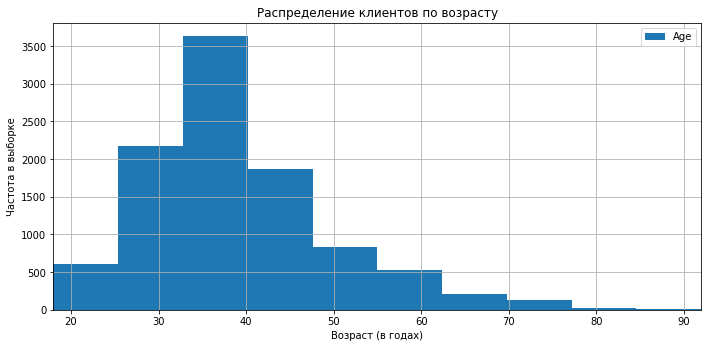

In [18]:
hist([data[['Age']]], xlab='Возраст (в годах)', ylab='Частота в выборке', title='Распределение клиентов по возрасту')

In [19]:
show_shares(data.query('Age < 20'), 'Age')

,Age,count,share
0,18,22,0.44898
1,19,27,0.55102


In [20]:
show_shares(data.query('Age > 70'), 'Age')

,Age,count,share
0,71,27,0.203008
1,72,21,0.157895
2,73,13,0.097744
3,74,18,0.135338
4,75,9,0.067669
5,76,11,0.082707
6,77,10,0.075188
7,78,5,0.037594
8,79,4,0.030075
9,80,3,0.022556


Оцениваем Tenure:

In [21]:
show_shares(data,'Tenure')

,Tenure,count,share
0,0.0,1291,0.1291
1,1.0,952,0.0952
2,2.0,950,0.0950
3,3.0,928,0.0928
4,4.0,885,0.0885
5,5.0,927,0.0927
6,6.0,881,0.0881
7,7.0,925,0.0925
8,8.0,933,0.0933
9,9.0,882,0.0882


В значениях Tenure проблем не видно; не будем править тип на int, это не даст нам ничего полезного

Оцениваем Balance (отрицательные, выбросы):

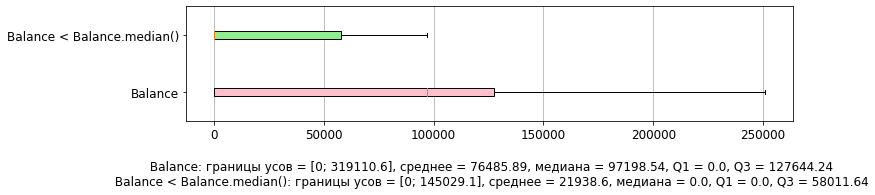

In [22]:
boxplot([\
        data[['Balance']],\
        data.query('Balance < Balance.median()')[['Balance']].rename(columns={'Balance':'Balance < Balance.median()'})
    ],\
    figsize=(12,3), fontsize=16
)

Оцениваем NumOfProducts:

In [23]:
show_shares(data,'NumOfProducts')

,NumOfProducts,count,share
0,1,5084,0.5084
1,2,4590,0.4590
2,3,266,0.0266
3,4,60,0.0060


Оцениваем HasCrCard:

In [24]:
show_shares(data,'HasCrCard')

,HasCrCard,count,share
0,0,2945,0.2945
1,1,7055,0.7055


Оцениваем IsActiveMember:

In [25]:
show_shares(data,'IsActiveMember')

,IsActiveMember,count,share
0,0,4849,0.4849
1,1,5151,0.5151


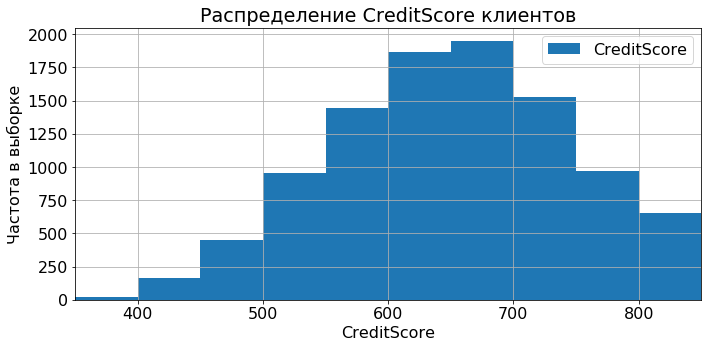

In [26]:
hist([data[['CreditScore']]], xlab='CreditScore', ylab='Частота в выборке', title='Распределение CreditScore клиентов')

<div class="alert alert-info">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Еще можно было бы посмотреть на матрицу корреляций
</div>

Оцениваем EstimatedSalary (отрицательные, выбросы):

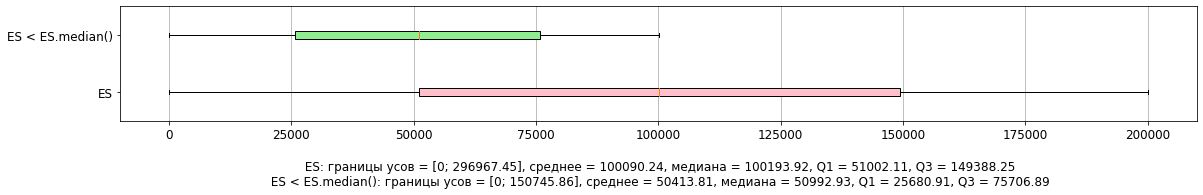

In [27]:
boxplot([\
        data[['EstimatedSalary']].rename(columns={'EstimatedSalary':'ES'}),\
        data.query('EstimatedSalary < EstimatedSalary.median()')[['EstimatedSalary']]\
         .rename(columns={'EstimatedSalary':'ES < ES.median()'})
    ],\
    figsize=(17,3), fontsize=16
)

Извлечем данные, которые не могут представлять ценности для установления значения целевого признака с точки зрения физики процессов.

К таким признакам, бесспорно, относятся: CustomerId, RowNumber и Surname:

In [28]:
data = data.drop(columns=['CustomerId','RowNumber','Surname'])

<div class="alert alert-success">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Верно, идентификаторы бесполезны для наших моделей - они белый шум
</div>

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


Посмотрим на категориальные Geography и Gender (на предмет чего-то нестандартного в данных) и выполним для них OHE:

In [30]:
show_shares(data, 'Geography')

,Geography,count,share
0,France,5014,0.5014
1,Germany,2509,0.2509
2,Spain,2477,0.2477


In [31]:
show_shares(data, 'Gender')

,Gender,count,share
0,Female,4543,0.4543
1,Male,5457,0.5457


In [32]:
data = pd.get_dummies(data,columns=['Gender','Geography'], drop_first=True)

<div class="alert alert-success">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Вопрос на подумать: подходит ли LE?
</div>

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
CreditScore          10000 non-null int64
Age                  10000 non-null int64
Tenure               10000 non-null float64
Balance              10000 non-null float64
NumOfProducts        10000 non-null int64
HasCrCard            10000 non-null int64
IsActiveMember       10000 non-null int64
EstimatedSalary      10000 non-null float64
Exited               10000 non-null int64
Gender_Male          10000 non-null uint8
Geography_Germany    10000 non-null uint8
Geography_Spain      10000 non-null uint8
dtypes: float64(3), int64(6), uint8(3)
memory usage: 732.5 KB


Ожидаемо, dummy-ловушку зависимых переменных при OHE-кодировании мы избежали

Что у нас с целевым признаком? Ожидаемо, дисбаланс:

In [34]:
show_shares(data,'Exited')

,Exited,count,share
0,0,7963,0.7963
1,1,2037,0.2037


<div class="alert alert-success">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Да, явный причем
</div>

In [35]:
udata = data.copy()

Разобьем на тренировочную (60%), валидационную (20%) и тестовую выборки (20%):

In [36]:
utarget = data['Exited']
ufeatures = data.drop(['Exited'], axis=1)
ufeat_train, ufeat_valid_and_test, utarg_train, utarg_valid_and_test = stratified_split(\
            ufeatures.copy(), utarget.copy(), test_size = 0.4)
ufeat_valid, ufeat_test, utarg_valid, utarg_test = stratified_split(\
            ufeat_valid_and_test.copy(), utarg_valid_and_test.copy(), test_size = 0.5)

In [37]:
def prescale_correction(df: pd.DataFrame) -> pd.DataFrame:
    data = df.copy().reset_index(drop=True)
    return data

In [38]:
ufeat_train = prescale_correction(ufeat_train)

In [39]:
ufeat_valid = prescale_correction(ufeat_valid)

In [40]:
ufeat_test = prescale_correction(ufeat_test)

In [41]:
utarg_train = prescale_correction(utarg_train)

In [42]:
utarg_valid = prescale_correction(utarg_valid)

In [43]:
utarg_test = prescale_correction(utarg_test)

Проверим соблюдение соотношений классов в выборках:

In [44]:
show_shares(ufeat_train.copy().assign(Exited = utarg_train),'Exited')

,Exited,count,share
0,0,4778,0.796333
1,1,1222,0.203667


In [45]:
show_shares(ufeat_valid.copy().assign(Exited = utarg_valid),'Exited')

,Exited,count,share
0,0,1592,0.796
1,1,408,0.204


In [46]:
show_shares(ufeat_test.copy().assign(Exited = utarg_test),'Exited')

,Exited,count,share
0,0,1593,0.7965
1,1,407,0.2035


и проведем масштабирование всех признаков:

In [48]:
scaler = StandardScaler()
columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Gender_Male', 'Geography_Germany', 'Geography_Spain']
scaler.fit(ufeat_train[columns])
ufeat_train[columns] = scaler.transform(ufeat_train[columns])
ufeat_valid[columns] = scaler.transform(ufeat_valid[columns])
ufeat_test[columns] = scaler.transform(ufeat_test[columns])

<div class="alert alert-info">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
А масштабирование бинарных признаков полезно? Будет ли разница?
</div>

In [50]:
ufeat_train

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_Male,Geography_Germany,Geography_Spain
0,-1.040434,0.953312,0.467449,0.774657,-0.914708,-1.525709,0.969466,-0.119110,-1.102198,1.739007,-0.575811
1,0.454006,-0.095244,-1.461501,1.910540,-0.914708,0.655433,0.969466,-0.258658,-1.102198,-0.575041,-0.575811
2,0.103585,-0.476537,1.110432,0.481608,0.820981,-1.525709,0.969466,1.422836,0.907278,-0.575041,-0.575811
3,-0.184996,0.190726,-1.461501,0.088439,-0.914708,0.655433,0.969466,-1.160427,-1.102198,1.739007,-0.575811
4,-0.720933,1.620574,-1.140009,0.879129,-0.914708,0.655433,-1.031496,0.113236,-1.102198,-0.575041,-0.575811
...,...,...,...,...,...,...,...,...,...,...,...
5995,-0.844611,0.381372,0.145957,0.180068,4.292357,0.655433,0.969466,0.117350,0.907278,1.739007,-0.575811
5996,-1.359935,0.190726,0.145957,0.547724,-0.914708,0.655433,-1.031496,-0.192524,-1.102198,1.739007,-0.575811
5997,-1.174418,0.476696,-0.175534,0.727840,-0.914708,-1.525709,-1.031496,0.531933,-1.102198,1.739007,-0.575811
5998,0.155118,2.287837,-1.461501,0.449382,-0.914708,0.655433,0.969466,-1.307769,0.907278,1.739007,-0.575811


# 2. Исследование задачи

Попробуем подобрать оптимальную модель по метрике F1 без учета дисбаланса.

Начнем с RandomForest (~3 минуты предположительно в то время, когда вряд ли есть загрузка):

In [51]:
rfc = ClassificationModelEvaluator(RandomForestClassifier())
rfc.set_hparams_ranges(
    {
        "random_state": [GLOBAL_RANDOM_STATE],
        "n_estimators": list(range(20,90,10)),
        "criterion": ['gini', 'entropy'],
        "max_depth": list(range(1,20))        
    } 
)
rfc_results = rfc.hparams_evaluation(ufeat_train, utarg_train, ufeat_valid, utarg_valid,return_only_optimal=False)
rfc_results.sort_values(by=['F1','auc_roc'], ascending=False).head(10)

,classifier,params,F1,threshold,auc_roc,prec,recall,fit_sec,best_score,best_time,best
91,RandomForestClassifier,"{'random_state': 12345, 'n_estimators': 40, 'criterion': 'gini', 'max_depth': 16}",0.648961,0.300018,0.858097,0.613537,0.688725,0.340168,True,False,True
159,RandomForestClassifier,"{'random_state': 12345, 'n_estimators': 60, 'criterion': 'gini', 'max_depth': 8}",0.645768,0.233262,0.872069,0.562842,0.757353,0.375497,False,False,False
127,RandomForestClassifier,"{'random_state': 12345, 'n_estimators': 50, 'criterion': 'gini', 'max_depth': 14}",0.643262,0.294753,0.863929,0.597895,0.696078,0.418143,False,False,False
104,RandomForestClassifier,"{'random_state': 12345, 'n_estimators': 40, 'criterion': 'entropy', 'max_depth': 10}",0.643226,0.239711,0.872016,0.556351,0.762255,0.341102,False,False,False
30,RandomForestClassifier,"{'random_state': 12345, 'n_estimators': 20, 'criterion': 'entropy', 'max_depth': 12}",0.643101,0.292851,0.857642,0.601279,0.691176,0.189252,False,False,False
51,RandomForestClassifier,"{'random_state': 12345, 'n_estimators': 30, 'criterion': 'gini', 'max_depth': 14}",0.641593,0.280856,0.861912,0.584677,0.710784,0.255295,False,False,False
180,RandomForestClassifier,"{'random_state': 12345, 'n_estimators': 60, 'criterion': 'entropy', 'max_depth': 10}",0.641471,0.230791,0.873744,0.549912,0.769608,0.510242,False,False,False
34,RandomForestClassifier,"{'random_state': 12345, 'n_estimators': 20, 'criterion': 'entropy', 'max_depth': 16}",0.641204,0.310867,0.848620,0.607456,0.678922,0.216675,False,False,False
150,RandomForestClassifier,"{'random_state': 12345, 'n_estimators': 50, 'criterion': 'entropy', 'max_depth': 18}",0.640909,0.300342,0.858547,0.597458,0.691176,0.623603,False,False,False
257,RandomForestClassifier,"{'random_state': 12345, 'n_estimators': 80, 'criterion': 'entropy', 'max_depth': 11}",0.640701,0.211713,0.872972,0.531502,0.806373,0.721133,False,False,False


Сохраним RandomForest-лидера для общего рейтинга:

In [52]:
rfc_leader = rfc_results.query('best == True')
leaders_df = rfc_leader.copy()
rfc_leader

,classifier,params,F1,threshold,auc_roc,prec,recall,fit_sec,best_score,best_time,best
91,RandomForestClassifier,"{'random_state': 12345, 'n_estimators': 40, 'criterion': 'gini', 'max_depth': 16}",0.648961,0.300018,0.858097,0.613537,0.688725,0.340168,True,False,True


Посмотрим на классификатор на базе логистической регрессии:

In [53]:
lrc = ClassificationModelEvaluator(LogisticRegression())
lrc.set_hparams_ranges(
    {
        "random_state": [GLOBAL_RANDOM_STATE],
        "penalty": ['l1', 'l2', 'elasticnet', 'none'],
        "solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        "multi_class": ['auto', 'ovr', 'multinomial']
    } 
)
lrc_results = lrc.hparams_evaluation(ufeat_train, utarg_train, ufeat_valid, utarg_valid,return_only_optimal=False)
lrc_results.sort_values(by=['F1','auc_roc'], ascending=False).head(10)

,classifier,params,F1,threshold,auc_roc,prec,recall,fit_sec,best_score,best_time,best
0,LogisticRegression,"{'random_state': 12345, 'penalty': 'l1', 'solver': 'liblinear', 'multi_class': 'auto'}",0.527290,0.227739,0.787570,0.423477,0.698529,0.019987,True,False,False
1,LogisticRegression,"{'random_state': 12345, 'penalty': 'l1', 'solver': 'liblinear', 'multi_class': 'ovr'}",0.527290,0.227739,0.787570,0.423477,0.698529,0.013476,True,False,True
4,LogisticRegression,"{'random_state': 12345, 'penalty': 'l1', 'solver': 'saga', 'multi_class': 'multinomial'}",0.526703,0.225019,0.787567,0.421829,0.700980,0.061277,False,False,False
2,LogisticRegression,"{'random_state': 12345, 'penalty': 'l1', 'solver': 'saga', 'multi_class': 'auto'}",0.526703,0.225047,0.787565,0.421829,0.700980,0.038061,False,False,False
3,LogisticRegression,"{'random_state': 12345, 'penalty': 'l1', 'solver': 'saga', 'multi_class': 'ovr'}",0.526703,0.225047,0.787565,0.421829,0.700980,0.034502,False,False,False
11,LogisticRegression,"{'random_state': 12345, 'penalty': 'l2', 'solver': 'liblinear', 'multi_class': 'auto'}",0.526123,0.224147,0.787573,0.420205,0.703431,0.099527,False,False,False
12,LogisticRegression,"{'random_state': 12345, 'penalty': 'l2', 'solver': 'liblinear', 'multi_class': 'ovr'}",0.526123,0.224147,0.787573,0.420205,0.703431,0.014398,False,False,False
15,LogisticRegression,"{'random_state': 12345, 'penalty': 'l2', 'solver': 'sag', 'multi_class': 'multinomial'}",0.526123,0.223793,0.787559,0.420205,0.703431,0.102896,False,False,False
30,LogisticRegression,"{'random_state': 12345, 'penalty': 'none', 'solver': 'saga', 'multi_class': 'multinomial'}",0.526123,0.223831,0.787558,0.420205,0.703431,0.047918,False,False,False
25,LogisticRegression,"{'random_state': 12345, 'penalty': 'none', 'solver': 'sag', 'multi_class': 'auto'}",0.526123,0.223832,0.787558,0.420205,0.703431,0.047758,False,False,False


In [54]:
lrc_leader = lrc_results.query('best == True')
leaders_df = pd.concat([leaders_df, lrc_leader])
lrc_leader

,classifier,params,F1,threshold,auc_roc,prec,recall,fit_sec,best_score,best_time,best
1,LogisticRegression,"{'random_state': 12345, 'penalty': 'l1', 'solver': 'liblinear', 'multi_class': 'ovr'}",0.52729,0.227739,0.78757,0.423477,0.698529,0.013476,True,False,True


И взглянем на классификатор на базе градиентного бустинга (~5 минут):

In [55]:
gbc = ClassificationModelEvaluator(GradientBoostingClassifier())
gbc.set_hparams_ranges(
    {
        "random_state": [GLOBAL_RANDOM_STATE],
        "n_estimators": list(range(40,80,10)),
        "max_depth": list(range(5,15))
    } 
)
gbc_results = gbc.hparams_evaluation(ufeat_train, utarg_train, ufeat_valid, utarg_valid,return_only_optimal=False)
gbc_results.sort_values(by=['F1','auc_roc'], ascending=False).head(10)

,classifier,params,F1,threshold,auc_roc,prec,recall,fit_sec,best_score,best_time,best
1,GradientBoostingClassifier,"{'random_state': 12345, 'n_estimators': 40, 'max_depth': 6}",0.651639,0.221476,0.876757,0.559859,0.779412,0.570401,True,False,True
11,GradientBoostingClassifier,"{'random_state': 12345, 'n_estimators': 50, 'max_depth': 6}",0.648430,0.210851,0.878041,0.552677,0.784314,0.717491,False,False,False
0,GradientBoostingClassifier,"{'random_state': 12345, 'n_estimators': 40, 'max_depth': 5}",0.648056,0.205131,0.878367,0.546218,0.796569,0.417654,False,True,False
21,GradientBoostingClassifier,"{'random_state': 12345, 'n_estimators': 60, 'max_depth': 6}",0.644269,0.194741,0.876860,0.539735,0.799020,0.935182,False,False,False
30,GradientBoostingClassifier,"{'random_state': 12345, 'n_estimators': 70, 'max_depth': 5}",0.642928,0.200282,0.877848,0.538972,0.796569,0.803774,False,False,False
20,GradientBoostingClassifier,"{'random_state': 12345, 'n_estimators': 60, 'max_depth': 5}",0.642220,0.200941,0.878332,0.539101,0.794118,0.604982,False,False,False
10,GradientBoostingClassifier,"{'random_state': 12345, 'n_estimators': 50, 'max_depth': 5}",0.641326,0.196763,0.879048,0.532362,0.806373,0.514629,False,False,False
31,GradientBoostingClassifier,"{'random_state': 12345, 'n_estimators': 70, 'max_depth': 6}",0.636451,0.180602,0.875830,0.524642,0.808824,0.976812,False,False,False
22,GradientBoostingClassifier,"{'random_state': 12345, 'n_estimators': 60, 'max_depth': 7}",0.635983,0.218921,0.868061,0.554745,0.745098,1.250503,False,False,False
2,GradientBoostingClassifier,"{'random_state': 12345, 'n_estimators': 40, 'max_depth': 7}",0.634441,0.205118,0.868651,0.538462,0.772059,0.760511,False,False,False


In [56]:
gbc_leader = gbc_results.query('best == True')
leaders_df = pd.concat([leaders_df, gbc_leader])
gbc_leader

,classifier,params,F1,threshold,auc_roc,prec,recall,fit_sec,best_score,best_time,best
1,GradientBoostingClassifier,"{'random_state': 12345, 'n_estimators': 40, 'max_depth': 6}",0.651639,0.221476,0.876757,0.559859,0.779412,0.570401,True,False,True


**Итог работы с несбалансированным датасетом**:

In [57]:
leaders_df.sort_values(by='F1', ascending=False) 

,classifier,params,F1,threshold,auc_roc,prec,recall,fit_sec,best_score,best_time,best
1,GradientBoostingClassifier,"{'random_state': 12345, 'n_estimators': 40, 'max_depth': 6}",0.651639,0.221476,0.876757,0.559859,0.779412,0.570401,True,False,True
91,RandomForestClassifier,"{'random_state': 12345, 'n_estimators': 40, 'criterion': 'gini', 'max_depth': 16}",0.648961,0.300018,0.858097,0.613537,0.688725,0.340168,True,False,True
1,LogisticRegression,"{'random_state': 12345, 'penalty': 'l1', 'solver': 'liblinear', 'multi_class': 'ovr'}",0.527290,0.227739,0.787570,0.423477,0.698529,0.013476,True,False,True


1. Логистическая регрессия достаточно беспомощна, хотя и фантастически быстра
1. GB, ожидаемо, обошел RF

<div class="alert alert-success">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Да, интересно посмотреть как повлияют техники борьбы с дисбалансом классов
</div>

# 3. Борьба с дисбалансом

Начнем с банального взвешивания классов:

In [58]:
wrfc = ClassificationModelEvaluator(RandomForestClassifier())
wrfc.set_hparams_ranges(
    {
        "random_state": [GLOBAL_RANDOM_STATE],
        "n_estimators": list(range(20,90,10)),
        "criterion": ['gini', 'entropy'],
        "max_depth": list(range(1,20)),
        "class_weight": ['balanced']
    } 
)
wrfc_results = wrfc.hparams_evaluation(ufeat_train, utarg_train, ufeat_valid, utarg_valid,return_only_optimal=False)
wrfc_results.sort_values(by=['F1','auc_roc'], ascending=False).head(10)

,classifier,params,F1,threshold,auc_roc,prec,recall,fit_sec,best_score,best_time,best
255,RandomForestClassifier,"{'random_state': 12345, 'n_estimators': 80, 'criterion': 'entropy', 'max_depth': 9, 'class_weight': 'balanced'}",0.651163,0.455798,0.872828,0.572491,0.754902,0.627538,True,False,True
104,RandomForestClassifier,"{'random_state': 12345, 'n_estimators': 40, 'criterion': 'entropy', 'max_depth': 10, 'class_weight': 'balanced'}",0.649948,0.433608,0.869076,0.566485,0.762255,0.338687,False,False,False
141,RandomForestClassifier,"{'random_state': 12345, 'n_estimators': 50, 'criterion': 'entropy', 'max_depth': 9, 'class_weight': 'balanced'}",0.645418,0.431869,0.872571,0.543624,0.794118,0.439242,False,False,False
45,RandomForestClassifier,"{'random_state': 12345, 'n_estimators': 30, 'criterion': 'gini', 'max_depth': 8, 'class_weight': 'balanced'}",0.642562,0.457826,0.869261,0.555357,0.762255,0.284900,False,False,False
234,RandomForestClassifier,"{'random_state': 12345, 'n_estimators': 80, 'criterion': 'gini', 'max_depth': 7, 'class_weight': 'balanced'}",0.642351,0.475003,0.870391,0.547496,0.776961,0.463204,False,False,False
70,RandomForestClassifier,"{'random_state': 12345, 'n_estimators': 30, 'criterion': 'entropy', 'max_depth': 14, 'class_weight': 'balanced'}",0.642140,0.354946,0.853520,0.588957,0.705882,0.289409,False,False,False
142,RandomForestClassifier,"{'random_state': 12345, 'n_estimators': 50, 'criterion': 'entropy', 'max_depth': 10, 'class_weight': 'balanced'}",0.641822,0.421554,0.869515,0.555556,0.759804,0.437044,False,False,False
178,RandomForestClassifier,"{'random_state': 12345, 'n_estimators': 60, 'criterion': 'entropy', 'max_depth': 8, 'class_weight': 'balanced'}",0.640324,0.459929,0.870441,0.545769,0.774510,0.450495,False,False,False
143,RandomForestClassifier,"{'random_state': 12345, 'n_estimators': 50, 'criterion': 'entropy', 'max_depth': 11, 'class_weight': 'balanced'}",0.640000,0.376629,0.867361,0.540541,0.784314,0.712633,False,False,False
220,RandomForestClassifier,"{'random_state': 12345, 'n_estimators': 70, 'criterion': 'entropy', 'max_depth': 12, 'class_weight': 'balanced'}",0.640000,0.358515,0.865056,0.560886,0.745098,0.659723,False,False,False


Эффект практически незаметен для RandomForest, хотя результат и лучше, чем для несбалансированного датасета

In [60]:
wrfc_leader = wrfc_results.query('best == True')
wleaders_df = wrfc_leader.copy()
wrfc_leader

,classifier,params,F1,threshold,auc_roc,prec,recall,fit_sec,best_score,best_time,best
255,RandomForestClassifier,"{'random_state': 12345, 'n_estimators': 80, 'criterion': 'entropy', 'max_depth': 9, 'class_weight': 'balanced'}",0.651163,0.455798,0.872828,0.572491,0.754902,0.627538,True,False,True


In [61]:
wlrc = ClassificationModelEvaluator(LogisticRegression())
wlrc.set_hparams_ranges(
    {
        "random_state": [GLOBAL_RANDOM_STATE],
        "penalty": ['l1', 'l2', 'elasticnet', 'none'],
        "solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        "multi_class": ['auto', 'ovr', 'multinomial'],
        "class_weight": ['balanced']
    } 
)
wlrc_results = wlrc.hparams_evaluation(ufeat_train, utarg_train, ufeat_valid, utarg_valid,return_only_optimal=False)
wlrc_results.sort_values(by=['F1','auc_roc'], ascending=False).head(10)

,classifier,params,F1,threshold,auc_roc,prec,recall,fit_sec,best_score,best_time,best
19,LogisticRegression,"{'random_state': 12345, 'penalty': 'none', 'solver': 'newton-cg', 'multi_class': 'auto', 'class_weight': 'balanced'}",0.53286,0.506167,0.793728,0.417827,0.735294,0.396795,True,False,False
20,LogisticRegression,"{'random_state': 12345, 'penalty': 'none', 'solver': 'newton-cg', 'multi_class': 'ovr', 'class_weight': 'balanced'}",0.53286,0.506167,0.793728,0.417827,0.735294,0.491629,True,False,False
21,LogisticRegression,"{'random_state': 12345, 'penalty': 'none', 'solver': 'newton-cg', 'multi_class': 'multinomial', 'class_weight': 'balanced'}",0.53286,0.506167,0.793728,0.417827,0.735294,0.064521,True,False,False
22,LogisticRegression,"{'random_state': 12345, 'penalty': 'none', 'solver': 'lbfgs', 'multi_class': 'auto', 'class_weight': 'balanced'}",0.53286,0.506162,0.793728,0.417827,0.735294,0.013825,True,False,False
23,LogisticRegression,"{'random_state': 12345, 'penalty': 'none', 'solver': 'lbfgs', 'multi_class': 'ovr', 'class_weight': 'balanced'}",0.53286,0.506162,0.793728,0.417827,0.735294,0.096398,True,False,False
28,LogisticRegression,"{'random_state': 12345, 'penalty': 'none', 'solver': 'saga', 'multi_class': 'auto', 'class_weight': 'balanced'}",0.53286,0.506163,0.793727,0.417827,0.735294,0.125242,True,False,False
29,LogisticRegression,"{'random_state': 12345, 'penalty': 'none', 'solver': 'saga', 'multi_class': 'ovr', 'class_weight': 'balanced'}",0.53286,0.506163,0.793727,0.417827,0.735294,0.119887,True,False,False
24,LogisticRegression,"{'random_state': 12345, 'penalty': 'none', 'solver': 'lbfgs', 'multi_class': 'multinomial', 'class_weight': 'balanced'}",0.53286,0.506168,0.793725,0.417827,0.735294,0.016843,True,False,False
7,LogisticRegression,"{'random_state': 12345, 'penalty': 'l2', 'solver': 'newton-cg', 'multi_class': 'multinomial', 'class_weight': 'balanced'}",0.53286,0.506188,0.793724,0.417827,0.735294,0.152893,True,False,False
18,LogisticRegression,"{'random_state': 12345, 'penalty': 'l2', 'solver': 'saga', 'multi_class': 'multinomial', 'class_weight': 'balanced'}",0.53286,0.506188,0.793724,0.417827,0.735294,0.152333,True,False,False


Небольшой прирост F1 (по сравнению с несбалансированной выборокой), хотя и не позволяющий достигнуть нужных нам значений на LogisticRegression-классификаторе

In [62]:
wlrc_leader = wlrc_results.query('best == True')
wleaders_df = pd.concat([wleaders_df, wlrc_leader])
wlrc_leader

,classifier,params,F1,threshold,auc_roc,prec,recall,fit_sec,best_score,best_time,best
12,LogisticRegression,"{'random_state': 12345, 'penalty': 'l2', 'solver': 'liblinear', 'multi_class': 'ovr', 'class_weight': 'balanced'}",0.53286,0.506273,0.793722,0.417827,0.735294,0.013341,True,True,True


Поскольку GradientBoostingClasifier не поддерживает параметр взвешивания (да и в силу своих особенностей должен не очень сильно реагировать на дисбаланс), то его мы пропустим на данном этапе

Хотелось бы посмотреть например SMOTE из imbalanced-learning, но есть проблемы с установкой (я не стал упорствовать, "сломавшись" на корретктности сопоставления safe_indexing для разных версий sklearn), поэтому делаем руками. Посчитаем коэффициет дисбаланса:

In [63]:
cdf = show_shares(utarg_train.to_frame(),'Exited')
disb_coeff = cdf['share'][0] / cdf['share'][1]
disb_coeff 

3.909983633387889

ok, округляем до 4 и делаем upsampling:

In [64]:
ups_feat_train, ups_targ_train = upsample(ufeat_train, utarg_train, 4)
show_shares(ups_feat_train.copy().assign(Exited = ups_targ_train),'Exited')


,Exited,count,share
0,0,4778,0.49431
1,1,4888,0.50569


Остановимся на этом. Теперь еще один прогон с upsampled-данными для обучения:

In [65]:
ups_rfc = ClassificationModelEvaluator(RandomForestClassifier())
ups_rfc.set_hparams_ranges(
    {
        "random_state": [GLOBAL_RANDOM_STATE],
        "n_estimators": list(range(20,90,10)),
        "criterion": ['gini', 'entropy'],
        "max_depth": list(range(1,20))
    } 
)
ups_rfc_results = ups_rfc.hparams_evaluation(ups_feat_train, ups_targ_train, ufeat_valid, utarg_valid,return_only_optimal=False)
ups_rfc_results.sort_values(by=['F1','auc_roc'], ascending=False).head(10)

,classifier,params,F1,threshold,auc_roc,prec,recall,fit_sec,best_score,best_time,best
159,RandomForestClassifier,"{'random_state': 12345, 'n_estimators': 60, 'criterion': 'gini', 'max_depth': 8}",0.651366,0.534130,0.869582,0.587771,0.730392,0.546004,True,False,True
83,RandomForestClassifier,"{'random_state': 12345, 'n_estimators': 40, 'criterion': 'gini', 'max_depth': 8}",0.648363,0.520718,0.869116,0.569573,0.752451,0.361151,False,False,False
6,RandomForestClassifier,"{'random_state': 12345, 'n_estimators': 20, 'criterion': 'gini', 'max_depth': 7}",0.646817,0.516246,0.868799,0.556537,0.772059,0.175842,False,False,False
253,RandomForestClassifier,"{'random_state': 12345, 'n_estimators': 80, 'criterion': 'entropy', 'max_depth': 7}",0.644540,0.532927,0.871818,0.572243,0.737745,0.773773,False,False,False
103,RandomForestClassifier,"{'random_state': 12345, 'n_estimators': 40, 'criterion': 'entropy', 'max_depth': 9}",0.643386,0.499352,0.870989,0.566108,0.745098,0.452341,False,False,False
238,RandomForestClassifier,"{'random_state': 12345, 'n_estimators': 80, 'criterion': 'gini', 'max_depth': 11}",0.642105,0.442170,0.868152,0.562731,0.747549,0.982840,False,False,False
104,RandomForestClassifier,"{'random_state': 12345, 'n_estimators': 40, 'criterion': 'entropy', 'max_depth': 10}",0.641237,0.483096,0.870411,0.553381,0.762255,0.468841,False,False,False
198,RandomForestClassifier,"{'random_state': 12345, 'n_estimators': 70, 'criterion': 'gini', 'max_depth': 9}",0.640000,0.465000,0.872957,0.540541,0.784314,0.871621,False,False,False
200,RandomForestClassifier,"{'random_state': 12345, 'n_estimators': 70, 'criterion': 'gini', 'max_depth': 11}",0.639498,0.440941,0.867541,0.557377,0.750000,0.795691,False,False,False
183,RandomForestClassifier,"{'random_state': 12345, 'n_estimators': 60, 'criterion': 'entropy', 'max_depth': 13}",0.639309,0.430062,0.869367,0.571429,0.725490,0.819033,False,False,False


Ожидаемо: существенных изменений по сравнению с weighted нет 

In [66]:
ups_rfc_leader = ups_rfc_results.query('best == True')
ups_leaders_df = ups_rfc_leader.copy()
ups_rfc_leader

,classifier,params,F1,threshold,auc_roc,prec,recall,fit_sec,best_score,best_time,best
159,RandomForestClassifier,"{'random_state': 12345, 'n_estimators': 60, 'criterion': 'gini', 'max_depth': 8}",0.651366,0.53413,0.869582,0.587771,0.730392,0.546004,True,False,True


In [67]:
ups_lrc = ClassificationModelEvaluator(LogisticRegression())
ups_lrc.set_hparams_ranges(
    {
        "random_state": [GLOBAL_RANDOM_STATE],
        "penalty": ['l1', 'l2', 'elasticnet', 'none'],
        "solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        "multi_class": ['auto', 'ovr', 'multinomial']
    } 
)
ups_lrc_results = ups_lrc.hparams_evaluation(ups_feat_train, ups_targ_train, ufeat_valid, utarg_valid,return_only_optimal=False)
ups_lrc_results.sort_values(by=['F1','auc_roc'], ascending=False).head(10)

,classifier,params,F1,threshold,auc_roc,prec,recall,fit_sec,best_score,best_time,best
0,LogisticRegression,"{'random_state': 12345, 'penalty': 'l1', 'solver': 'liblinear', 'multi_class': 'auto'}",0.53286,0.512545,0.793817,0.417827,0.735294,0.018599,True,False,False
1,LogisticRegression,"{'random_state': 12345, 'penalty': 'l1', 'solver': 'liblinear', 'multi_class': 'ovr'}",0.53286,0.512545,0.793817,0.417827,0.735294,0.017680,True,False,False
4,LogisticRegression,"{'random_state': 12345, 'penalty': 'l1', 'solver': 'saga', 'multi_class': 'multinomial'}",0.53286,0.512429,0.793814,0.417827,0.735294,0.104887,True,False,False
8,LogisticRegression,"{'random_state': 12345, 'penalty': 'l2', 'solver': 'lbfgs', 'multi_class': 'auto'}",0.53286,0.512081,0.793807,0.417827,0.735294,0.102470,True,False,False
9,LogisticRegression,"{'random_state': 12345, 'penalty': 'l2', 'solver': 'lbfgs', 'multi_class': 'ovr'}",0.53286,0.512081,0.793807,0.417827,0.735294,0.013935,True,True,True
2,LogisticRegression,"{'random_state': 12345, 'penalty': 'l1', 'solver': 'saga', 'multi_class': 'auto'}",0.53286,0.512407,0.793805,0.417827,0.735294,0.053766,True,False,False
3,LogisticRegression,"{'random_state': 12345, 'penalty': 'l1', 'solver': 'saga', 'multi_class': 'ovr'}",0.53286,0.512407,0.793805,0.417827,0.735294,0.050528,True,False,False
11,LogisticRegression,"{'random_state': 12345, 'penalty': 'l2', 'solver': 'liblinear', 'multi_class': 'auto'}",0.53286,0.512123,0.793805,0.417827,0.735294,0.018721,True,False,False
12,LogisticRegression,"{'random_state': 12345, 'penalty': 'l2', 'solver': 'liblinear', 'multi_class': 'ovr'}",0.53286,0.512123,0.793805,0.417827,0.735294,0.107895,True,False,False
13,LogisticRegression,"{'random_state': 12345, 'penalty': 'l2', 'solver': 'sag', 'multi_class': 'auto'}",0.53286,0.512131,0.793805,0.417827,0.735294,0.156167,True,False,False


In [68]:
ups_lrc_leader = ups_lrc_results.query('best == True')
ups_leaders_df = pd.concat([ups_leaders_df, ups_lrc_leader])
ups_lrc_leader

,classifier,params,F1,threshold,auc_roc,prec,recall,fit_sec,best_score,best_time,best
9,LogisticRegression,"{'random_state': 12345, 'penalty': 'l2', 'solver': 'lbfgs', 'multi_class': 'ovr'}",0.53286,0.512081,0.793807,0.417827,0.735294,0.013935,True,True,True


Ничего нового по сравнению с weighted

In [69]:
ups_gbc = ClassificationModelEvaluator(GradientBoostingClassifier())
ups_gbc.set_hparams_ranges(
    {
        "random_state": [GLOBAL_RANDOM_STATE],
        "n_estimators": list(range(40,80,10)),
        "max_depth": list(range(5,15))
    } 
)
ups_gbc_results = ups_gbc.hparams_evaluation(ups_feat_train, ups_targ_train, ufeat_valid, utarg_valid,return_only_optimal=False)
ups_gbc_results.sort_values(by=['F1','auc_roc'], ascending=False).head(10)

,classifier,params,F1,threshold,auc_roc,prec,recall,fit_sec,best_score,best_time,best
20,GradientBoostingClassifier,"{'random_state': 12345, 'n_estimators': 60, 'max_depth': 5}",0.658947,0.529716,0.879208,0.577491,0.767157,1.042319,True,False,True
0,GradientBoostingClassifier,"{'random_state': 12345, 'n_estimators': 40, 'max_depth': 5}",0.658147,0.545523,0.879106,0.581921,0.757353,0.789464,False,True,False
10,GradientBoostingClassifier,"{'random_state': 12345, 'n_estimators': 50, 'max_depth': 5}",0.656379,0.514687,0.879969,0.565603,0.781863,0.842283,False,False,False
30,GradientBoostingClassifier,"{'random_state': 12345, 'n_estimators': 70, 'max_depth': 5}",0.649485,0.511802,0.878883,0.560498,0.772059,1.162547,False,False,False
1,GradientBoostingClassifier,"{'random_state': 12345, 'n_estimators': 40, 'max_depth': 6}",0.640483,0.481298,0.873058,0.543590,0.779412,0.895253,False,False,False
21,GradientBoostingClassifier,"{'random_state': 12345, 'n_estimators': 60, 'max_depth': 6}",0.639216,0.445167,0.872641,0.532680,0.799020,1.386272,False,False,False
31,GradientBoostingClassifier,"{'random_state': 12345, 'n_estimators': 70, 'max_depth': 6}",0.638256,0.440706,0.872016,0.535774,0.789216,1.478809,False,False,False
11,GradientBoostingClassifier,"{'random_state': 12345, 'n_estimators': 50, 'max_depth': 6}",0.634336,0.443031,0.873025,0.524880,0.801471,1.176957,False,False,False
3,GradientBoostingClassifier,"{'random_state': 12345, 'n_estimators': 40, 'max_depth': 8}",0.625971,0.498185,0.855868,0.572008,0.691176,1.734329,False,False,False
32,GradientBoostingClassifier,"{'random_state': 12345, 'n_estimators': 70, 'max_depth': 7}",0.621491,0.371470,0.867016,0.513600,0.786765,2.024182,False,False,False


In [70]:
ups_gbc_leader = ups_gbc_results.query('best == True')
ups_leaders_df = pd.concat([ups_leaders_df, ups_gbc_leader])
ups_gbc_leader

,classifier,params,F1,threshold,auc_roc,prec,recall,fit_sec,best_score,best_time,best
20,GradientBoostingClassifier,"{'random_state': 12345, 'n_estimators': 60, 'max_depth': 5}",0.658947,0.529716,0.879208,0.577491,0.767157,1.042319,True,False,True


Ожидаемо, GradientBoostingClassifier индиффирентен к сбалансированности выборки

Не будем мучать downsampling :)

**Что в итоге?**

In [71]:
pd.concat([ups_leaders_df, wleaders_df]).sort_values(by=['F1','auc_roc'], ascending=False).head(10)

,classifier,params,F1,threshold,auc_roc,prec,recall,fit_sec,best_score,best_time,best
20,GradientBoostingClassifier,"{'random_state': 12345, 'n_estimators': 60, 'max_depth': 5}",0.658947,0.529716,0.879208,0.577491,0.767157,1.042319,True,False,True
159,RandomForestClassifier,"{'random_state': 12345, 'n_estimators': 60, 'criterion': 'gini', 'max_depth': 8}",0.651366,0.534130,0.869582,0.587771,0.730392,0.546004,True,False,True
255,RandomForestClassifier,"{'random_state': 12345, 'n_estimators': 80, 'criterion': 'entropy', 'max_depth': 9, 'class_weight': 'balanced'}",0.651163,0.455798,0.872828,0.572491,0.754902,0.627538,True,False,True
9,LogisticRegression,"{'random_state': 12345, 'penalty': 'l2', 'solver': 'lbfgs', 'multi_class': 'ovr'}",0.532860,0.512081,0.793807,0.417827,0.735294,0.013935,True,True,True
12,LogisticRegression,"{'random_state': 12345, 'penalty': 'l2', 'solver': 'liblinear', 'multi_class': 'ovr', 'class_weight': 'balanced'}",0.532860,0.506273,0.793722,0.417827,0.735294,0.013341,True,True,True


<div class="alert alert-success">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
За табличку сводную лайк. Логгирование - полезная вещь;)
</div>

Лучше всех по F1 - GradientBoostingClassifier

Его и будем использовать при тестировании

<div class="alert alert-success">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Можно было еще попробовать ансамбли попробовать из лучших моделей
</div>

# 4. Тестирование модели

In [72]:
ups_gbc.score_model(ufeat_test, utarg_test)

,classifier,params,F1,auc_roc,prec,recall
0,GradientBoostingClassifier,"{'random_state': 12345, 'n_estimators': 60, 'max_depth': 5}",0.596791,0.851187,0.528409,0.685504


<div class="alert alert-info">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Можно было бы еще вывести confusion матрицу + реализовать дамми модели, тем самым подтвердив адекватность наших моделей
</div>

<div class="alert alert-success">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Бейзлайн успешно побит, поздравляю!
</div>

Условия задачи выполнены. Поглядим на ROC-кривую нашего лидера (не зря же код писали):

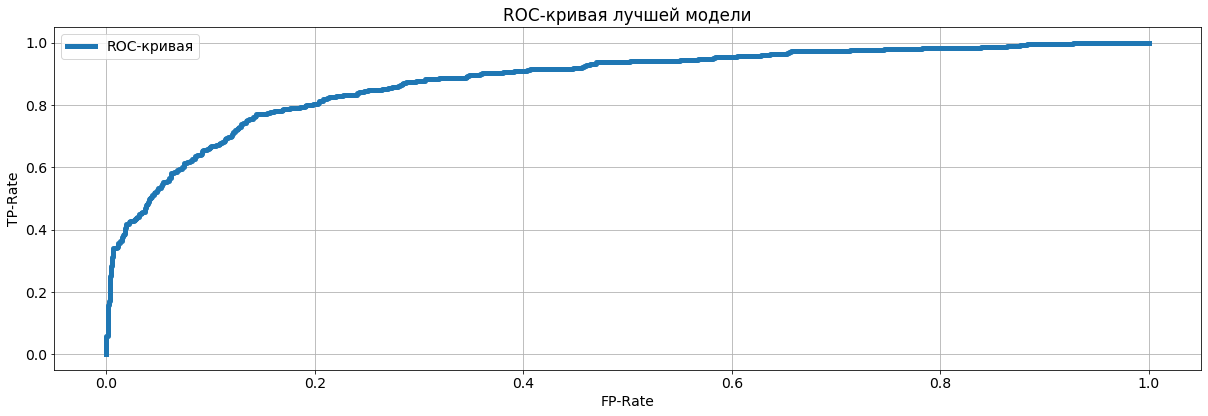

In [74]:
series_name_x_y_dict = { }
series_name_x_y_dict['ROC-кривая'] = {
    'x': ups_gbc.best_metrics[5],
    'y': ups_gbc.best_metrics[6],
}   
line(
    series_name_x_y_dict, 
    xlab='FP-Rate',
    ylab='TP-Rate', 
    title='ROC-кривая лучшей модели', 
    figsize=(17,6), 
    fontsize=14)

На всякий случай: может есть какой-то "сильно доминирующий" признак? Да, возраст доминирует, но не абсолютно (а от географических признаков вполне можно избавиться в принципе, как и от Gender, IsActiveMember или Tenure):

In [76]:
pd.DataFrame([ufeat_test.columns,ups_gbc.best_model.feature_importances_])

,0,1,2,3,4,5,6,7,8,9,10
0,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_Male,Geography_Germany,Geography_Spain
1,0.0389542,0.363882,0.0128829,0.142556,0.233859,0.000805731,0.0760368,0.0610546,0.0158381,0.0467433,0.00738763


Но это - история будущих спринтов.

<div class="alert alert-success">
<h2> Комментарий ревьюера</h2>
Большое спасибо за проделанную работу. Видно, что приложено много усилий.

- Соблюдена структура проекта 

- Код написан хорошо

- Сильное исследование, спасибо, было приятно проверять!

- Твои модели добились хороших результатов, поздравляю!


Успехов в следующих проектах!

</div>

# Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*